# Ασαφής αλγόριθμος ομαδοποίησης c-μέσων (fuzzy c-means)

Ο αλγόριθμος προσπαθεί να ελαχιστοποιήσει τη συνάρτηση:
$$\sum\limits_{j=1}^k \sum\limits_{x_i \in C_j} u_{ij}^m (x_i - c_j)^2 $$
όπου:

*   $u_{ij}$  είναι ο βαθμός συμμετοχής κατά τον οποίο η παρατήρηση $x_i$ ανήκει στην ομάδα  $c_j$ (membership)
*   $c_j$ είναι το κέντρο της ομάδας $j$
*   $m$ είναι ο ασαφοποιητής (fuzzyfier)

Μπορούμε να δούμε ότι ο c-means διαφέρει από τον k-means ως προς τον βαθμό συμμετοχής $u_{ij}$ και τον ασαφοποιητή $m$.

Η μεταβλητή $u_{ij}^m$ υπολογίζεται από τη σχέση
$$u_{ij}^m = \frac{1}{\sum\limits_{l=1}^k \left( \frac{| x_i - c_j |}{| x_i - c_k |}\right)^{\frac{2}{m-1}}}$$

Ο βαθμός συμμετοχής είναι αντίστροφα ανάλογος από την απόσταση από το κέντρο της ομάδας.

Στην ασαφή ομοδοποίηση το κέντρο κάθε ομάδας είναι ο μέση τιμή όλων των σημείων ζυγισμένο το καθένα με το βαθμό συμμετοχής του στην ομάδα:

$$c_j = \frac{\sum\limits_{x \in C_j} u_{ij}^m x}{\sum\limits_{x \in C_j} u_{ij}^m}$$

Ο αλγόριθμος ασαφούς ομαδοποίησης λειτουργεί ως εξής:

1. Ορίζουμε τον αριθμό των ομάδων c. (υπερπαράμετρος) 
2. Αναθέτουμε σε κάθε σημείο τυχαίους συντελεστές συμμετοχής στις ομάδες. Πρέπει να αθροίζουν στο 1 για κάθε σημείο.
3. Για τον μέγιστο αριθμό επαναλήψεων ή μέχρις ότου ο αλγόριθμος "συγκλίνει"  (δηλαδή οι συντελεστές αλλάζουν λίγοτερο από ένα κατώφλι $\epsilon$ επαναλαμβάνουμε:
- Υπολογίζουμε το κέντρο κάθε ομάδας.
- Για κάθε σημείο, υπολογίζουμε το βαθμό συμμετοχής του για όλες τις ομάδες.

Η παράμετρος $m$ είναι ένας πραγματικός αριθμός με τιμές μεγαλύτερες του 1 ($1.0<m<\infty$) και καθορίζει το βαθμό της ασάφειας. Μια τιμή κοντά στο 1 δίνει μια ομαδοποίηση κοντά στη σκληρή ομαδοποίηση του k-means, μια τιμή στο άπειρο οδηγεί σε μια ομαδοποίηση πλήρους ασάφειας. 

Στην πράξη η πιο συνηθισμένη τιμή είναι $m=2$

Τον c-means θα μας τον δώσει η βιβλιοθήκη scikit-fuzzy  [skfuzzy](https://pythonhosted.org/scikit-fuzzy/)


In [0]:
!pip install -U scikit-fuzzy

     |████████████████████████████████| 1.0MB 2.8MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp36-none-any.whl size=894069 sha256=4274e4b22e49a8241ea676922d0eff3218befec348efbf71fafe440b66e9c018
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


## Δημιουργία ψευδοτυχαίων δεδομένων

Σημειώστε πως μπορούμε να ελέγχουμε την κατεύθυνση των Γκαουσιανών με τη διακύμανση που ορίζουμε στον κάθε άξονα (sigmas)

Text(0.5, 1.0, 'Test data: 200 points x3 clusters.')

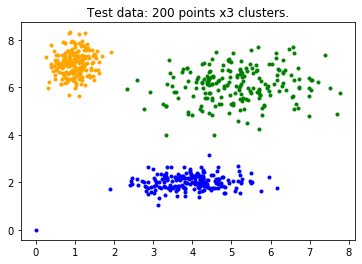

In [0]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']

# Define three cluster centers
centers = [[4, 2],
           [1, 7],
           [5, 6]]

# Define three cluster sigmas in x and y, respectively
sigmas = [[0.8, 0.3],
          [0.3, 0.5],
          [1.1, 0.7]]

# Generate test data
np.random.seed(42)  # Set seed for reproducibility
xpts = np.zeros(1)
ypts = np.zeros(1)
labels = np.zeros(1)
for i, ((xmu, ymu), (xsigma, ysigma)) in enumerate(zip(centers, sigmas)):
    xpts = np.hstack((xpts, np.random.standard_normal(200) * xsigma + xmu))
    ypts = np.hstack((ypts, np.random.standard_normal(200) * ysigma + ymu))
    labels = np.hstack((labels, np.ones(200) * i))

# Visualize the test data
fig0, ax0 = plt.subplots()
for label in range(3):
    ax0.plot(xpts[labels == label], ypts[labels == label], '.',
             color=colors[label])
ax0.set_title('Test data: 200 points x3 clusters.')

## Eύρεση του βέλτιστου αριθμού ομάδων c
Στο παράδειγμά μας έχουμε φτιάξει ελεγχόμενα 3 clusters. Σε ένα κανονικό πρόβλημα όμως δεν γνωρίζουμε από πριν τον βέλτιστο αριθμό ομάδων. Σημειώστε επίσης ότι στα παραδείγματά μας έχουμε μόνο δυο διαστάσεις, ένα τυπικό πρόβλημα έχει πολύ περρισσότερες.

Θα τρέξουμε τον αλγόριθμο για c από 2 μέχρι 10 ομάδες:

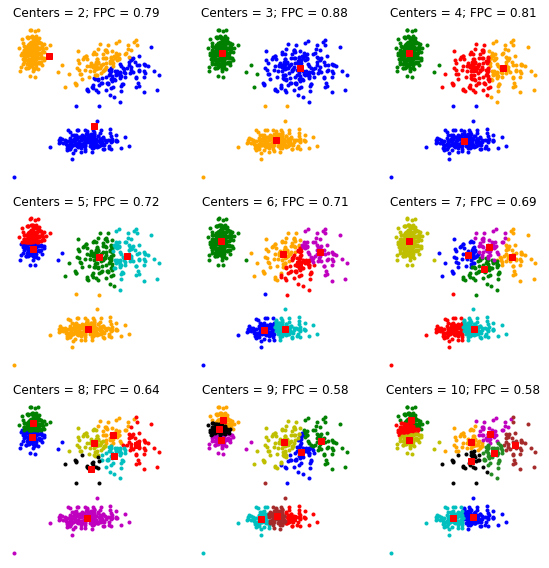

In [0]:
# Set up the loop and plot
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')
d
fig1.tight_layout()

Και θα χρησιμοποιήσουμε τον συντελεστή ασάφειας του διαμερισμού (fuzzy partition coefficient) ή συντελεστή Dunn

$$ F(U) = \frac{1}{n} \sum\limits_{i=1}^k\sum\limits_{j=1}^nu_{ij}^2$$

που είναι το άθροισμα των τετραγώνων όλων των βαθμών συμμετοχής δια του πλήθους των σημείων. Ο συντελεστής Dunn παίρνει τιμές

$$\frac{1}{k} \leq F(U) \leq 1$$

Το κάτω όριο επιτυγχάνεται όταν όλοι οι βαθμοί συμμετοχής είναι $\frac{1}{k}$ (απόλυτη ασάφεια, όλα τα σημεία ανήκουν σε όλες ομάδες κατά τον ίδιο βαθμό) και το άνω ($1$) όταν έχουμε μόνο μία ομάδα (τετριμμένη περίπτωση).

Text(0, 0.5, 'Fuzzy partition coefficient')

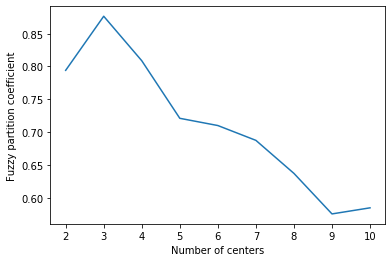

In [0]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")

Συνεπώς το βέλτιστο είναι c=3. Κάνουμε clustering με αυτό το c:

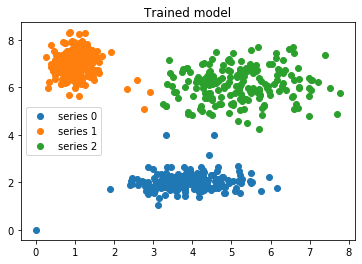

In [0]:
# Regenerate fuzzy model with 3 cluster centers - note that center ordering
# is random in this clustering algorithm, so the centers may change places
cntr, u_orig, _, _, _, _, _ = fuzz.cluster.cmeans(
    alldata, 3, 2, error=0.005, maxiter=1000)

# Show 3-cluster model
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(3):
    ax2.plot(alldata[0, u_orig.argmax(axis=0) == j],
             alldata[1, u_orig.argmax(axis=0) == j], 'o',
             label='series ' + str(j))
ax2.legend()

## Βαθμοί συμμετοχής τυχαίου σημείου
Για να δούμε πόσο ανήκει σε κάθε ομάδα ένα σημείο θα χρησιμοποιήσουμε τον πίνακα $u$

In [0]:
randompoint=10
print(alldata[:,randompoint])
print(u_orig[:,randompoint])

[4.43404803 3.15581945]
[0.83157629 0.04517197 0.12325175]


## Μειονεκτήματα

Ο αλγόριθμος c-means ελαχιστοποιεί τη διακύμανση εντός των ομάδων (intra-cluster variance) και μας δίνει τους βαθμούς συμμετοχής, έχει όμως τα ίδια προβλήματα με τον k-means:
* η βελτιστοποίηση καταλήγει σε ένα τοπικό ελάχιστο
* διαφορετική αρχικοποίηση δίνει διαφορετικά αποτελέσματα
* οι ομάδες έχουν αναγκαστικά κυκλικό σχήμα